In [175]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','grid'])
from sklearn.model_selection import train_test_split
import random
from copy import deepcopy

In [261]:
def get_attribute_train_test_matrix(path):
    matrix = pd.read_csv(path,index_col=0).to_numpy()
    Xs = matrix[:,:-1]
    Y = matrix[:,-1]
    Xs = StandardScaler().fit_transform(Xs)

    Xs = torch.tensor(Xs,dtype=torch.float32)
    Y = torch.tensor(Y,dtype=torch.float32)
    train_indices, test_indices = train_test_split(list(range(len(Y))),test_size=0.2,random_state=42)
    return (Xs[train_indices],Y[train_indices]), (Xs[test_indices],Y[test_indices])
def get_attribute_matrix(path):
    matrix = pd.read_csv(path,index_col=0).to_numpy()
    Xs = matrix[:,:-1]
    Y = matrix[:,-1]
    Xs = StandardScaler().fit_transform(Xs)

    Xs = torch.tensor(Xs,dtype=torch.float32)
    Y = torch.tensor(Y,dtype=torch.float32)
    return Xs,Y
train,test = get_attribute_train_test_matrix('train_dataset.csv')

In [263]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        # 初始化线性回归模型
        self.model = LinearRegression()

    def forward(self,Xs):
        return self.model(Xs)

    def train(self,train_data,test_data,output_plt=True):
        # 拟合模型
        train_Xs, train_Y = train_data
        test_Xs, test_Y = test_data

        self.model.fit(train_Xs, train_Y)
        # 打印系数和截距
        y_pred_train = self.model.predict(train_Xs)
        print(f"Train Results: \n \t Mean Squared Error: {mean_squared_error(train_Y, y_pred_train)}\n\tR2 Score:{r2_score(train_Y, y_pred_train)}")
        print("\tCoefficients:", self.model.coef_)
        print("\tIntercept:", self.model.intercept_)


        y_pred_test = self.model.predict(test_Xs)
        print(f"Test Results: \n \t Mean Squared Error: {mean_squared_error(test_Y, y_pred_test)}\n\tR2 Score:{r2_score(test_Y,y_pred_test)}")


        if output_plt:
            plt.figure(figsize=(6, 6), dpi=500)
            plt.scatter(train_Y.detach().numpy(), y_pred_train, label='Training Set', alpha=0.7)
            plt.scatter(test_Y.detach().numpy(), y_pred_test, label='Validation Set', alpha=0.7)
            max_val = max(max(train_Y), max(test_Y), max(y_pred_train), max(y_pred_test))
            min_val = min(min(train_Y), min(test_Y), min(y_pred_train), min(y_pred_test))
            plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='y = x')

            # 添加图例
            plt.legend()

            # 添加标题和标签
            plt.title('Actual vs Predicted Values')
            plt.xlabel('Actual Values')
            plt.ylabel('Predicted Values')
            plt.savefig("LR.pdf")

In [271]:
class MLP(nn.Module):
    def __init__(self,feature_dim = 3, layer_num = 8, hidden_size = 8):
        super().__init__()
        self.embedding = nn.Linear(feature_dim,hidden_size)
        layers = []
        for _ in range(layer_num - 1):
                layers.append(nn.Linear(hidden_size, hidden_size))
                layers.append(nn.ReLU())
                # layers.append(nn.Dropout(0.1))

        self.MLP = nn.Sequential(*layers)


        self.best_model_params = None
        self.best_r2 = 0
    def forward(self,Xs):
        out = self.embedding(Xs)
        out = nn.Sigmoid()(out)
        out = self.MLP(out)
        out = nn.ReLU()(out)
        out = out.mean(-1)
        return out

    def train(self,train_data,test_data,epoch_num=5000,output_plt = True):
        # 拟合模型
        train_Xs, train_Y = train_data
        test_Xs, test_Y = test_data

        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(),lr=1e-3)

        for epoch in range(epoch_num):
            # 打乱数据
            permutation = torch.randperm(train_Xs.size(0))
            shuffled_Xs = train_Xs[permutation]
            shuffled_Y = train_Y[permutation]

            y_pred_train = model(shuffled_Xs)
            optimizer.zero_grad()
            loss = criterion(shuffled_Y, y_pred_train)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 1000 == 0:
                print(f"Epoch {epoch}: "
                      f"Training Results:\n\t"
                      f"MSE Loss: {loss}\n\t"
                      f"R2 Score:{r2_score(shuffled_Y.detach().numpy(),y_pred_train.detach().numpy())}\n\n")

                y_pred_test = self(test_Xs)
                mse = mean_squared_error(test_Y.detach().numpy(), y_pred_test.detach().numpy())
                r2 = r2_score(test_Y.detach().numpy(),y_pred_test.detach().numpy())
                print(f"Test Results: \n \t "
                      f"MSE Loss: {mse}\n\t"
                      f"R2 Score:{r2}")
                if r2 > self. best_r2:
                    self.best_r2 = r2
                    self.best_model_params = deepcopy(self.state_dict())


        ##test
        self.load_state_dict(self.best_model_params)
        y_pred_test = self(test_Xs)
        print(f"Test Results: \n \t "
              f"MSE Loss: {mean_squared_error(test_Y.detach().numpy(), y_pred_test.detach().numpy())}\n\t"
              f"R2 Score:{r2_score(test_Y.detach().numpy(),y_pred_test.detach().numpy())}")

        if output_plt:
            plt.figure(figsize=(6, 6), dpi=500)
            y_pred_train = model(train_Xs).detach().numpy()
            y_pred_test = model(test_Xs).detach().numpy()
            plt.scatter(train_Y.detach().numpy(), y_pred_train, label='Training Set', alpha=0.7)
            plt.scatter(test_Y.detach().numpy(), y_pred_test, label='Validation Set', alpha=0.7)
            max_val = max(max(train_Y), max(test_Y), max(y_pred_train), max(y_pred_test))
            min_val = min(min(train_Y), min(test_Y), min(y_pred_train), min(y_pred_test))
            plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='y = x')

            # 添加图例
            plt.legend()

            # 添加标题和标签
            plt.title('Actual vs Predicted Values')
            plt.xlabel('Actual Values')
            plt.ylabel('Predicted Values')
            plt.savefig("MLP.pdf")

In [272]:
class Mixture(nn.Module):
    def __init__(self,feature_dim = 3, layer_num = 8, hidden_size = 8):
        super().__init__()
        self.LinearRegression = LinearRegressionModel()

        self.embedding = nn.Linear(feature_dim,hidden_size)
        layers = []
        for _ in range(layer_num - 1):
                layers.append(nn.Linear(hidden_size, hidden_size))
                layers.append(nn.ReLU())
                # layers.append(nn.Dropout(0.1))

        self.MLP = nn.Sequential(*layers)


        self.best_model_params = None
        self.best_r2 = 0
    def forward(self,Xs):
        lr_pred = self.LinearRegression.model.predict(Xs)
        lr_pred = torch.tensor(lr_pred)

        out = self.embedding(Xs)
        out = nn.Sigmoid()(out)
        out = self.MLP(out)
        out = nn.ReLU()(out)
        out = out.mean(-1)
        out = out + lr_pred
        return out

    def train(self,train_data,test_data,epoch_num=5000,output_plt = True):
        # 拟合模型
        train_Xs, train_Y = train_data
        test_Xs, test_Y = test_data

        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(),lr=1e-3)

        self.LinearRegression.model.fit(train_Xs, train_Y)
        for epoch in range(epoch_num):
            # 打乱数据
            permutation = torch.randperm(train_Xs.size(0))
            shuffled_Xs = train_Xs[permutation]
            shuffled_Y = train_Y[permutation]

            y_pred_train = model(shuffled_Xs)
            optimizer.zero_grad()
            loss = criterion(shuffled_Y, y_pred_train)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 100 == 0:
                # print(f"Epoch {epoch}: "
                #       f"Training Results:\n\t"
                #       f"MSE Loss: {loss}\n\t"
                #       f"R2 Score:{r2_score(shuffled_Y.detach().numpy(),y_pred_train.detach().numpy())}\n\n")

                y_pred_test = self(test_Xs)
                mse = mean_squared_error(test_Y.detach().numpy(), y_pred_test.detach().numpy())
                r2 = r2_score(test_Y.detach().numpy(),y_pred_test.detach().numpy())
                # print(f"Test Results: \n \t "
                #       f"MSE Loss: {mse}\n\t"
                #       f"R2 Score:{r2}")
                if r2 > self. best_r2:
                    self.best_r2 = r2
                    self.best_model_params = deepcopy(self.state_dict())


        ##test
        self.load_state_dict(self.best_model_params)
        y_pred_test = self(test_Xs)
        print(f"Test Results: \n \t "
              f"MSE Loss: {mean_squared_error(test_Y.detach().numpy(), y_pred_test.detach().numpy())}\n\t"
              f"R2 Score:{r2_score(test_Y.detach().numpy(),y_pred_test.detach().numpy())}")

        if output_plt:
            plt.figure(figsize=(6, 6), dpi=500)
            y_pred_train = model(train_Xs).detach().numpy()
            y_pred_test = model(test_Xs).detach().numpy()
            plt.scatter(train_Y.detach().numpy(), y_pred_train, label='Training Set', alpha=0.7)
            plt.scatter(test_Y.detach().numpy(), y_pred_test, label='Validation Set', alpha=0.7)
            max_val = max(max(train_Y), max(test_Y), max(y_pred_train), max(y_pred_test))
            min_val = min(min(train_Y), min(test_Y), min(y_pred_train), min(y_pred_test))
            plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='y = x')

            # 添加图例
            plt.legend()

            # 添加标题和标签
            plt.title('Actual vs Predicted Values')
            plt.xlabel('Actual Values')
            plt.ylabel('Predicted Values')
            plt.savefig("Mixture.pdf")

In [284]:
def setup_seed(seed):
    torch.backends.cudnn.deterministic = True
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)  # cpu
    torch.cuda.manual_seed(seed)  # gpu
    torch.cuda.manual_seed_all(seed)  # all gpus
setup_seed(42)

In [288]:
test_Xs,_ = get_attribute_matrix("test_dataset.csv")

Train Results: 
 	 Mean Squared Error: 32.90542221069336
	R2 Score:0.6130178633900831
	Coefficients: [ 5.813342    0.16676259 -3.05001   ]
	Intercept: 22.136627
Test Results: 
 	 Mean Squared Error: 67.90577697753906
	R2 Score:0.20426302794112117


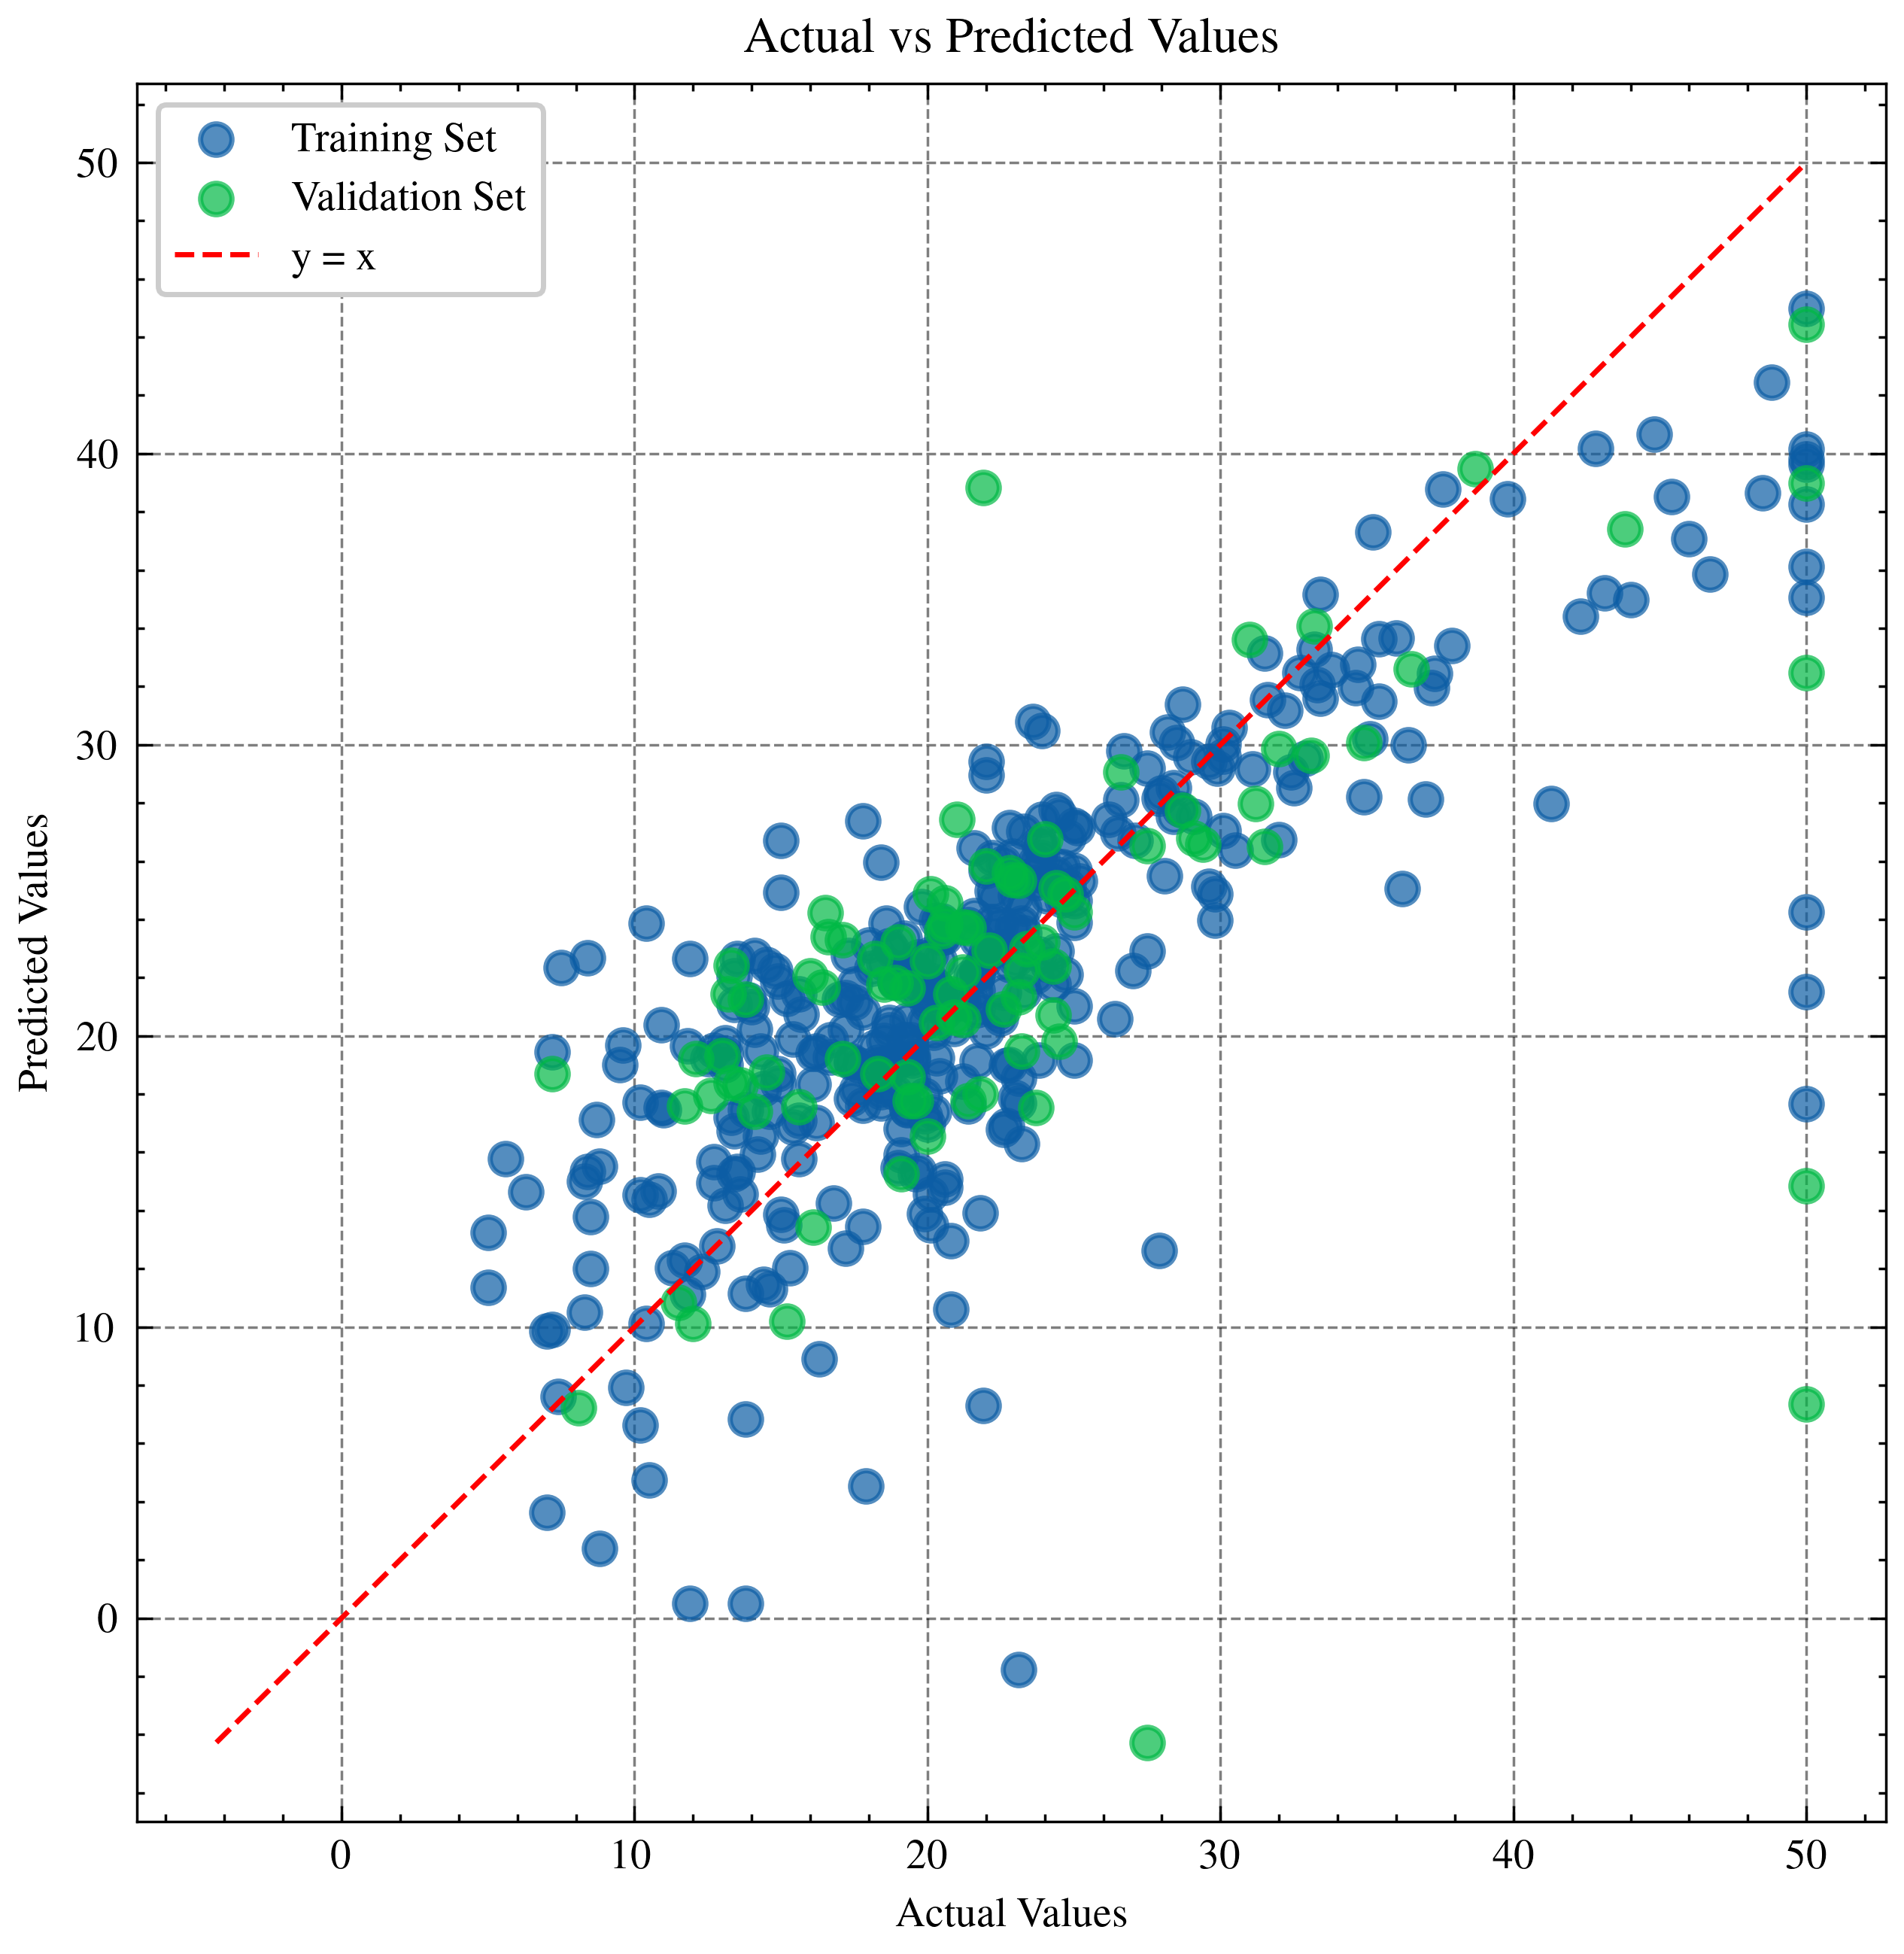

In [290]:
model = LinearRegressionModel()
model.train(*get_attribute_train_test_matrix("train_dataset.csv"),output_plt=True)
results_lr = model.model.predict(test_Xs)

Epoch 999: Training Results:
	MSE Loss: 24.480133056640625
	R2 Score:0.712102924612744


Test Results: 
 	 MSE Loss: 49.30195236206055
	R2 Score:0.4222673507301572
Epoch 1999: Training Results:
	MSE Loss: 23.881879806518555
	R2 Score:0.7191386705297864


Test Results: 
 	 MSE Loss: 47.31600570678711
	R2 Score:0.44553919588833146
Epoch 2999: Training Results:
	MSE Loss: 23.0537109375
	R2 Score:0.7288782723465222


Test Results: 
 	 MSE Loss: 43.980323791503906
	R2 Score:0.4846275432692009
Epoch 3999: Training Results:
	MSE Loss: 22.216047286987305
	R2 Score:0.7387295360944883


Test Results: 
 	 MSE Loss: 45.30040740966797
	R2 Score:0.4691584490211931
Epoch 4999: Training Results:
	MSE Loss: 21.545808792114258
	R2 Score:0.7466118678089826


Test Results: 
 	 MSE Loss: 45.74936294555664
	R2 Score:0.4638975410331909
Epoch 5999: Training Results:
	MSE Loss: 21.225479125976562
	R2 Score:0.7503790907615424


Test Results: 
 	 MSE Loss: 47.126441955566406
	R2 Score:0.44776056715141466
Epoch 6

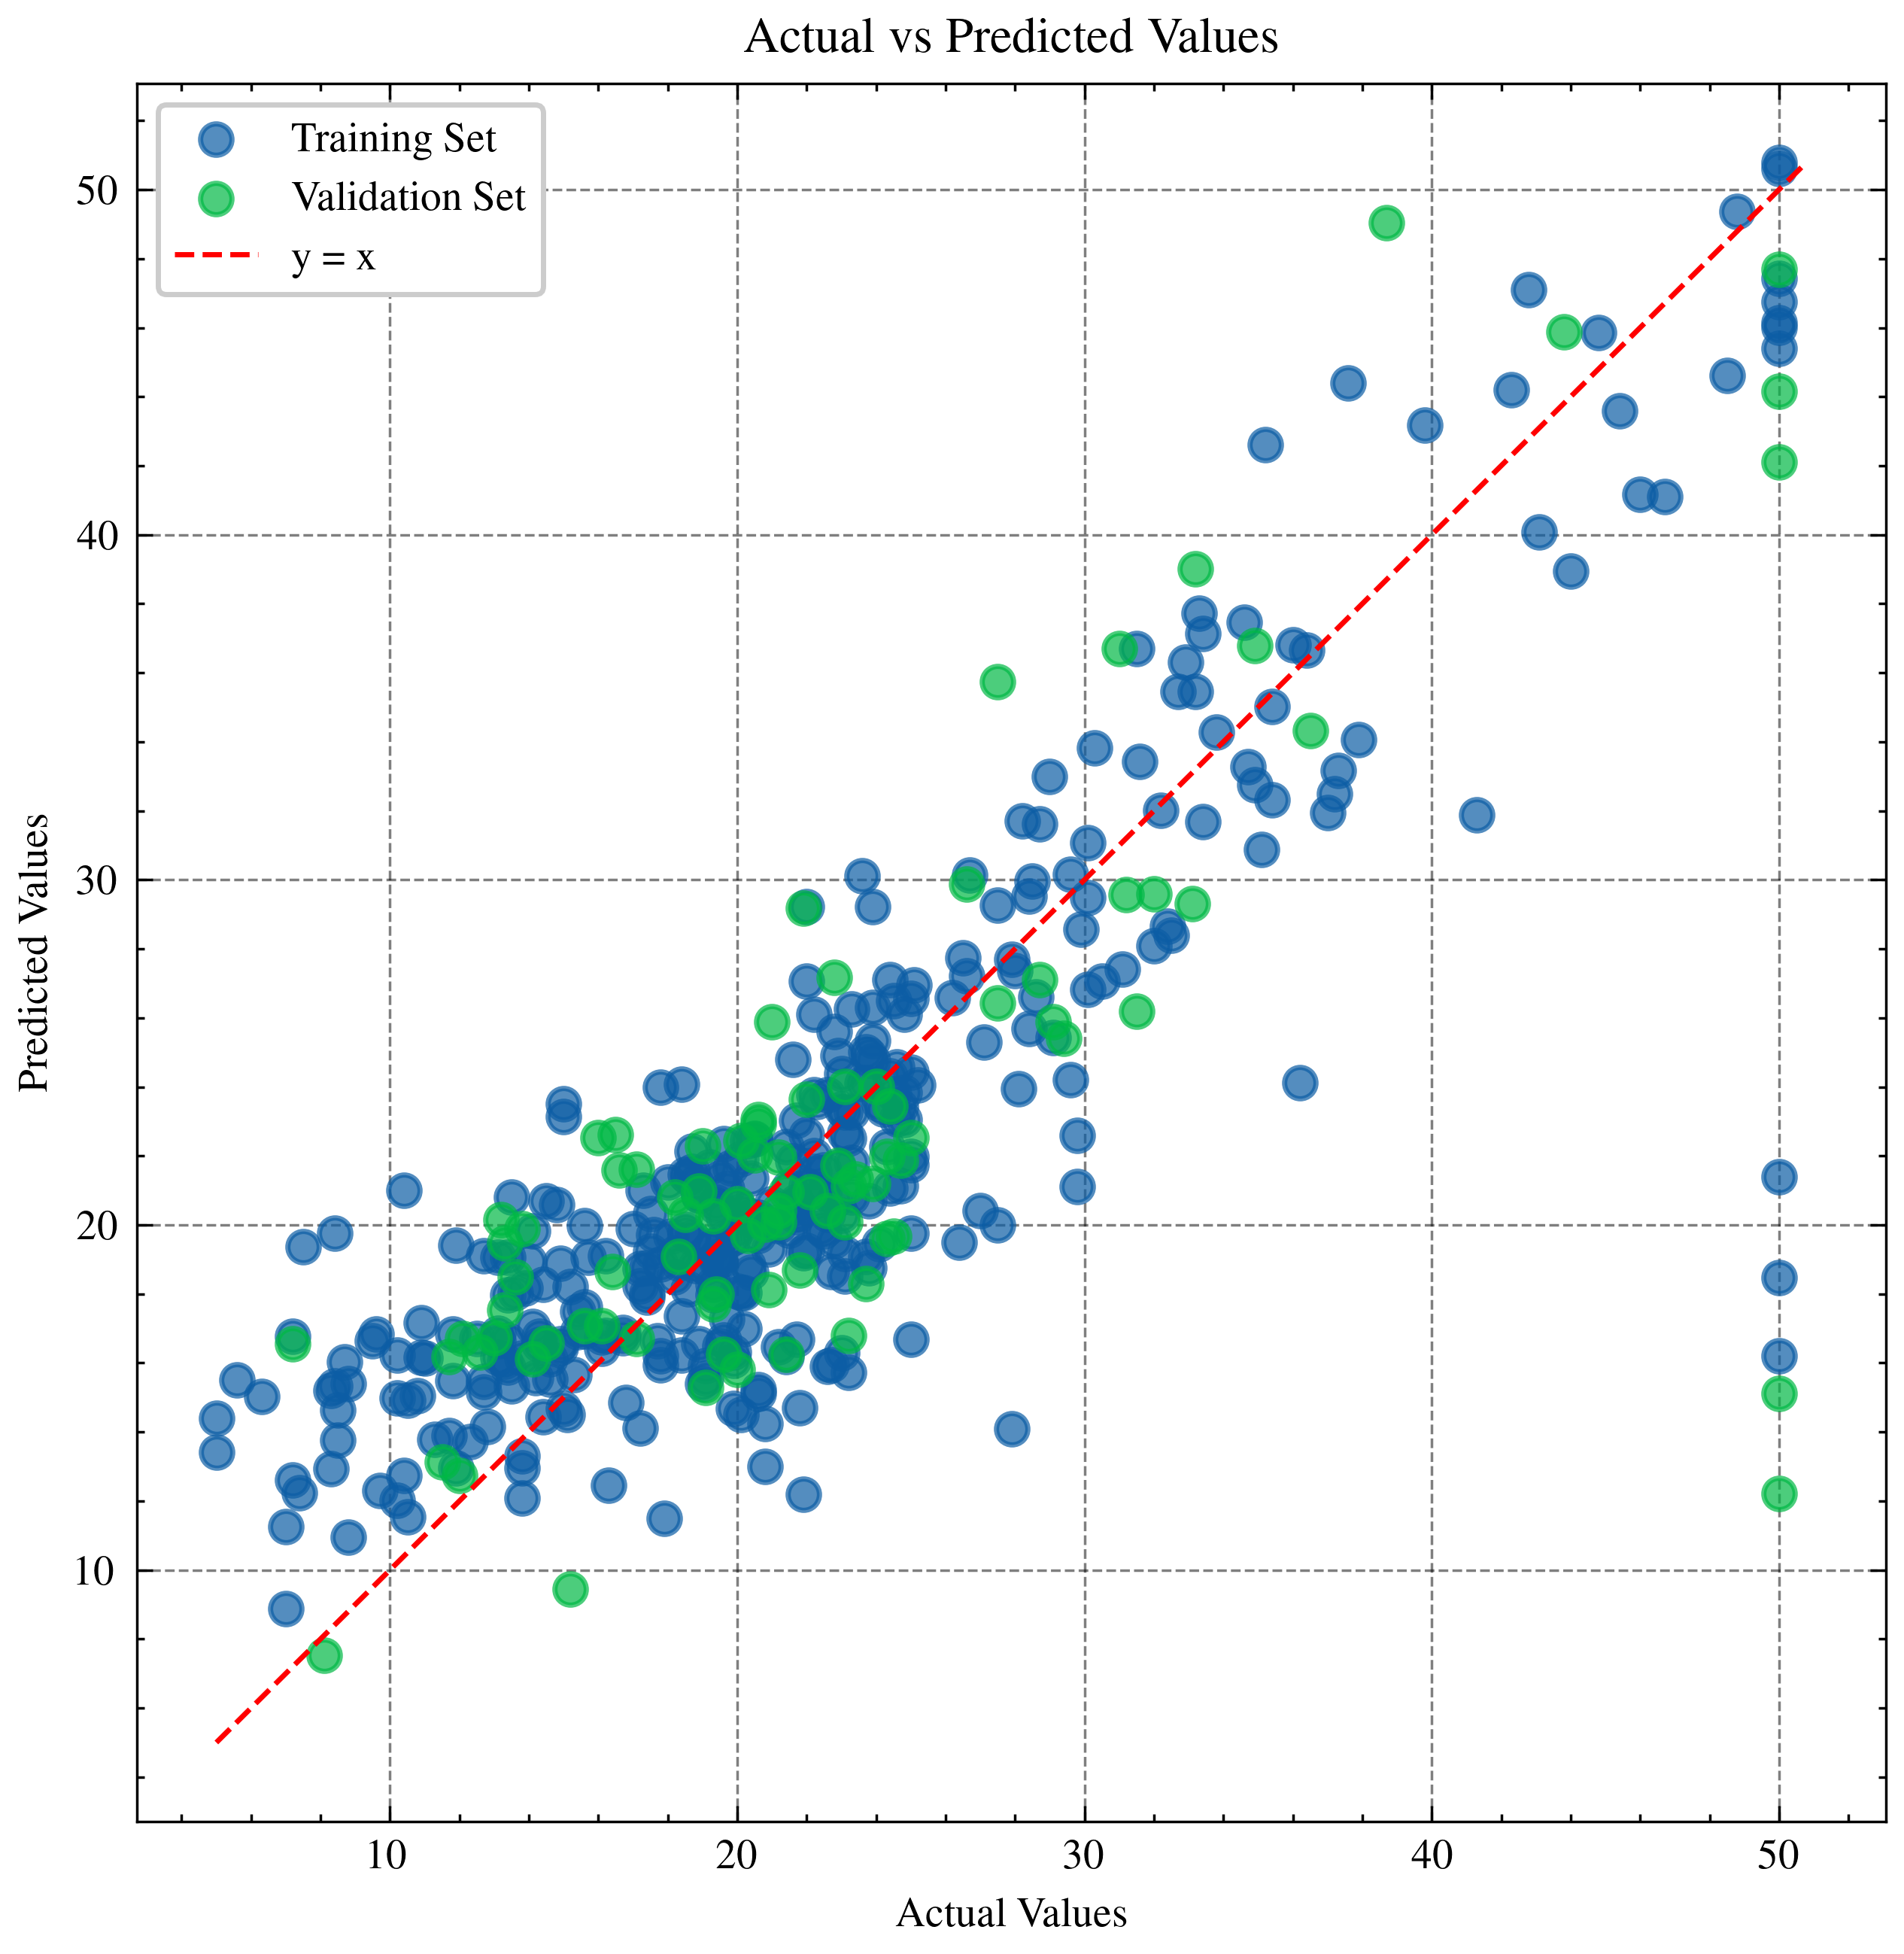

In [291]:
model = MLP(layer_num=5,hidden_size=64)
model.train(*get_attribute_train_test_matrix("train_dataset.csv"),epoch_num=10000,output_plt=True)
results_mlp = model(test_Xs)

Test Results: 
 	 MSE Loss: 50.338497161865234
	R2 Score:0.41012085833531065


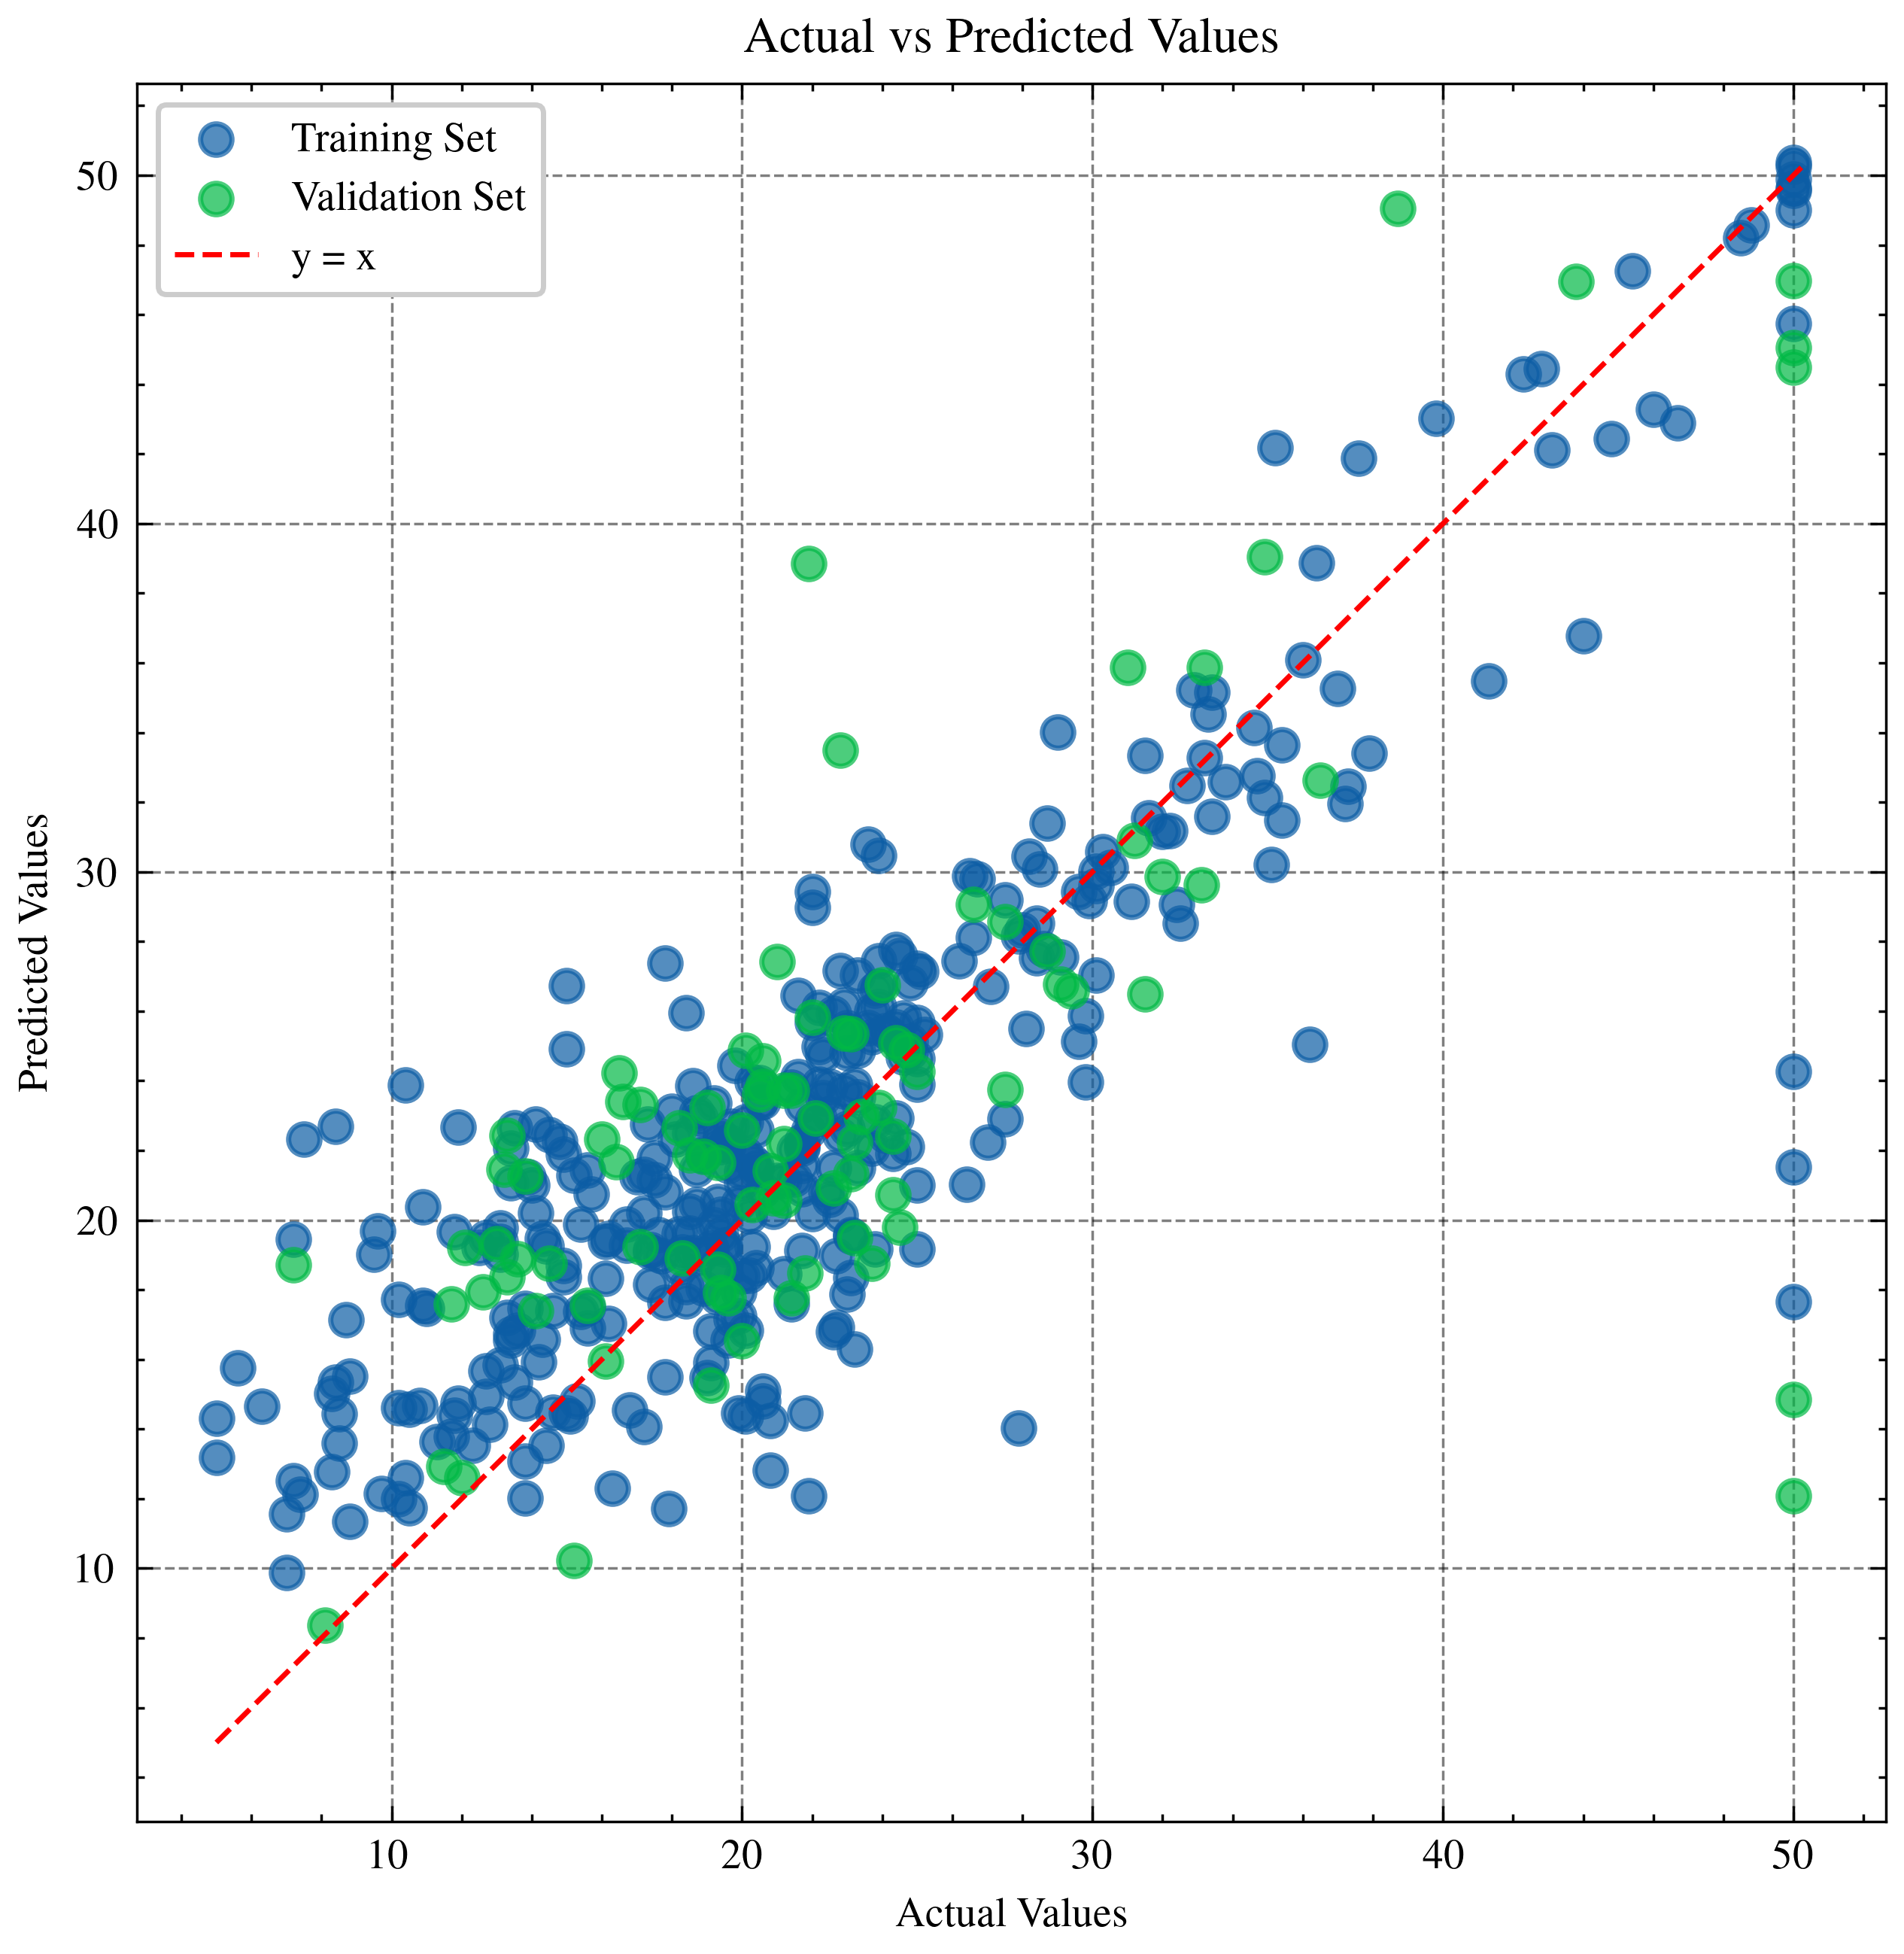

In [292]:
model = Mixture(layer_num=5,hidden_size=64)
model.train(*get_attribute_train_test_matrix("train_dataset.csv"),epoch_num=10000,output_plt=True)
results_mix = model(test_Xs)

In [314]:
pd.DataFrame(torch.cat([torch.tensor(pd.read_csv('test_dataset.csv').to_numpy()[:,:4]),
                        torch.tensor(results_lr).unsqueeze(-1),
                        results_mlp.unsqueeze(-1).detach(),
                        results_mix.unsqueeze(-1).detach()],-1),
             columns=['ID','RM','RAD','TAX','PRICE_LR','PRICE_MLP','PRICE_MIX']).to_csv('results.csv')